In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

In [2]:
def analysis_plot(solution_df: pd.DataFrame):
    # Set 'time-step' as the index
    solution_df.set_index('time-step', inplace=True)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Parameters over Time Steps')

    # Plot each parameter in a separate subplot
    for (param, ax) in zip(solution_df.columns, axs.ravel()):
        solution_df[param].plot(ax=ax, marker='o')
        ax.set_title(param)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [3]:
def calculate_stats(df: pd.DataFrame):
    # Calculate mean and median for each column
    results = {}
    for column in df.columns:
        results[column] = {
            "mean": df[column].mean(),
            "median": df[column].median()
        }
    
    return results

In [4]:
solution_artem_v1_df = pd.read_json('../data/solution_artem_v1_analysis.json')
solution_example_df = pd.read_json('../data/solution_example_analysis.json')

FileNotFoundError: File ../data/solution_artem_v1_analysis.json does not exist

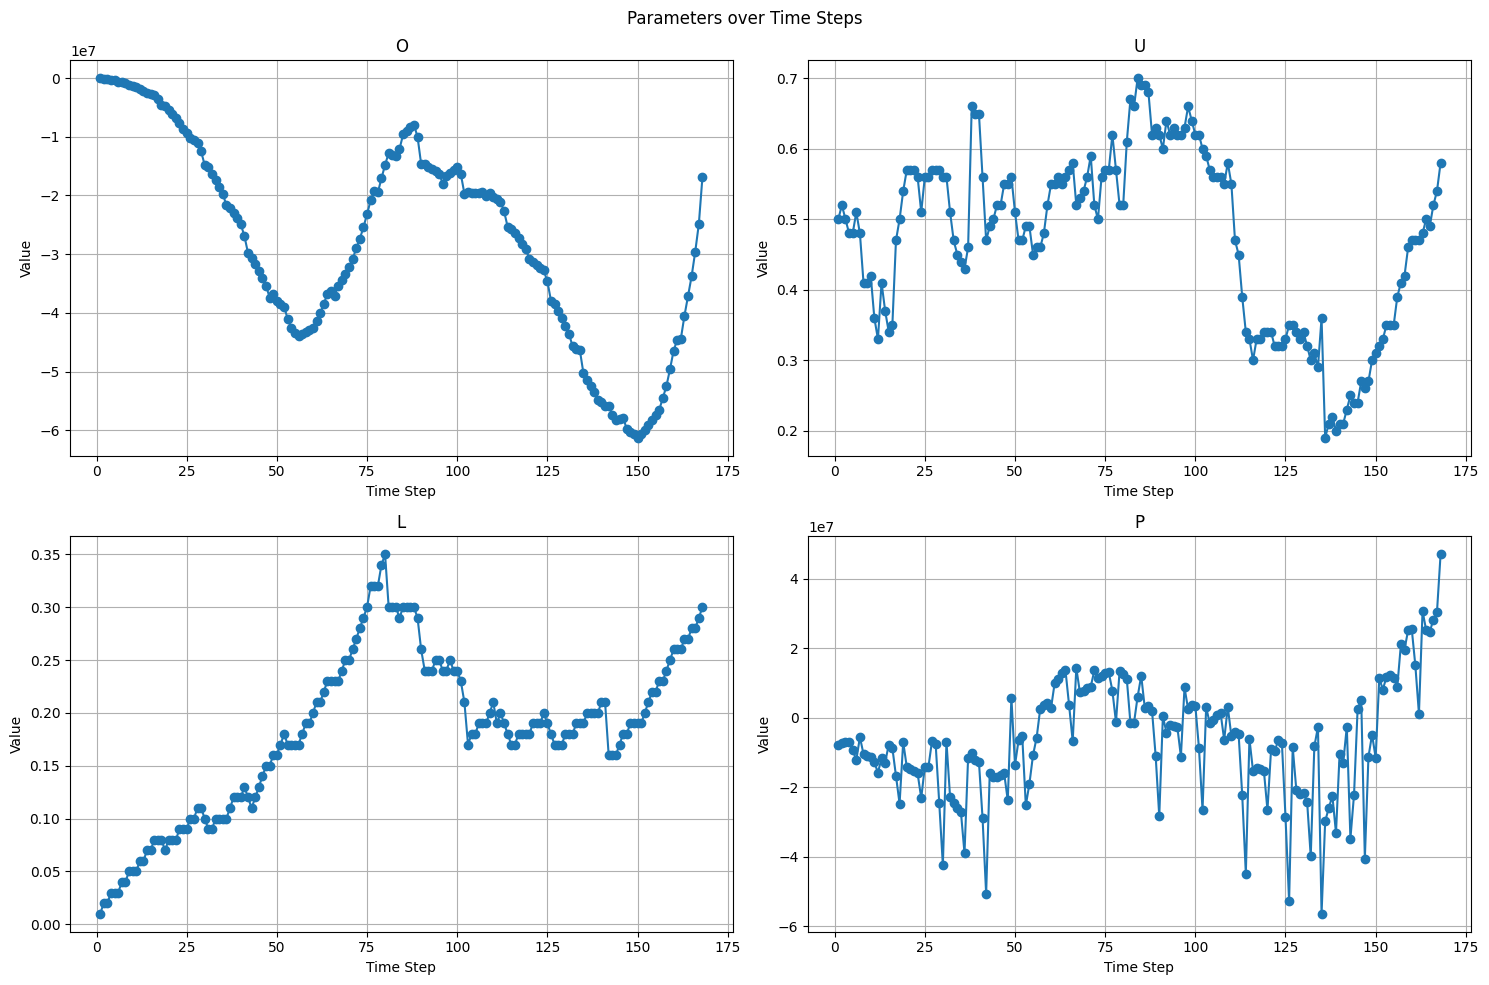

In [ ]:
analysis_plot(solution_artem_v1_df)

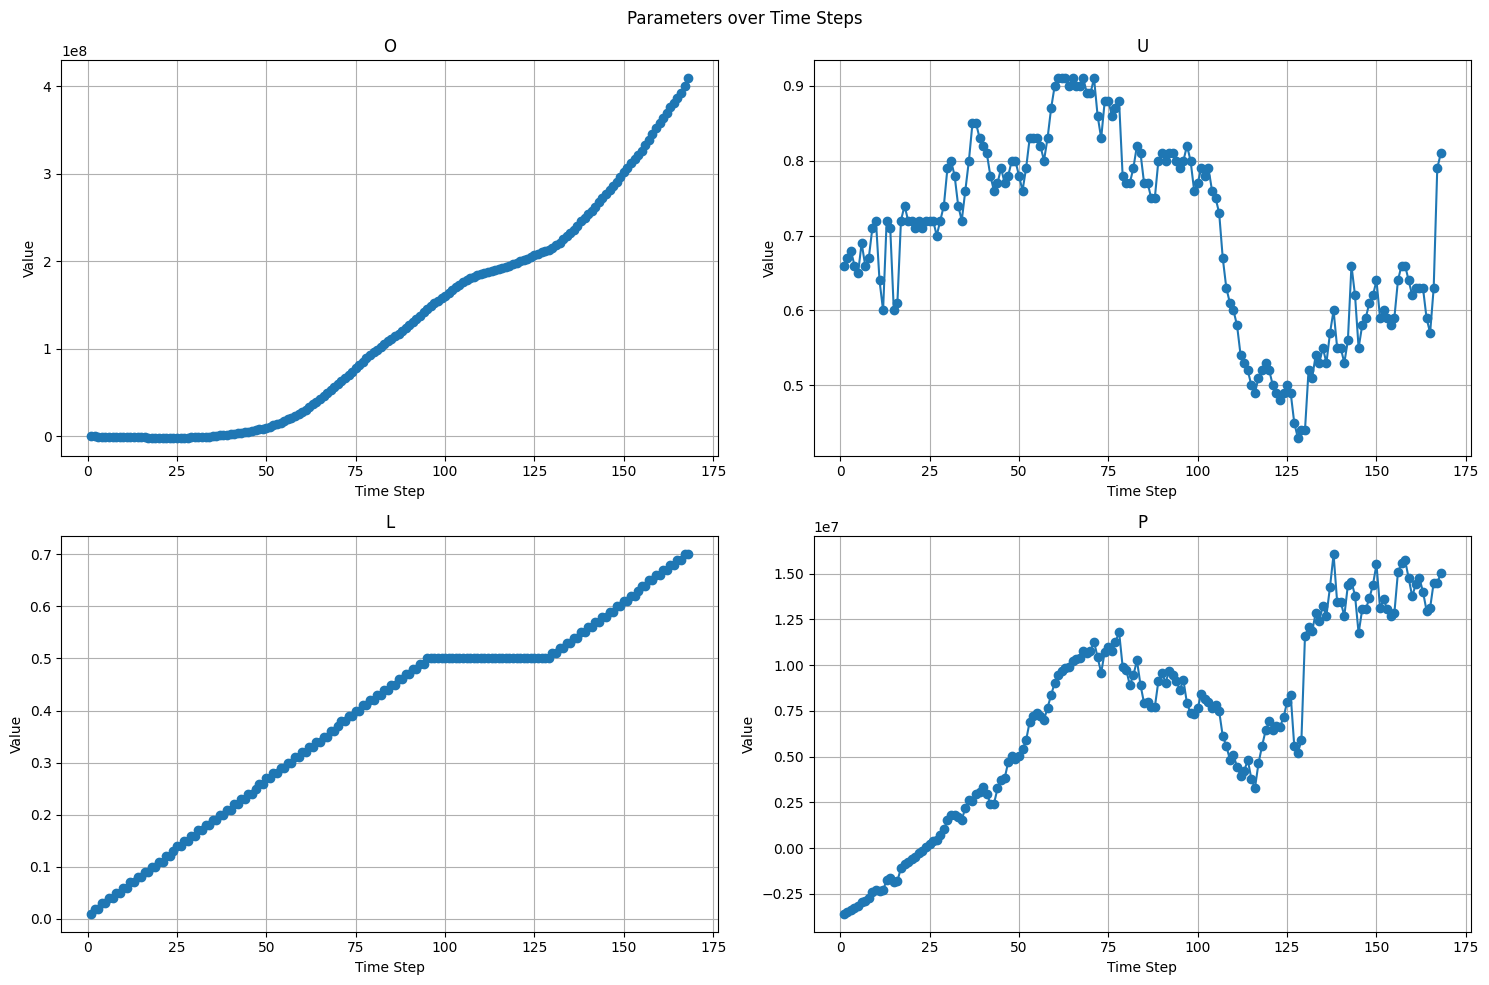

In [ ]:
analysis_plot(solution_example_df)

In [5]:
calculate_stats(solution_artem_v1_df)

NameError: name 'solution_artem_v1_df' is not defined

In [ ]:
calculate_stats(solution_example_df)

{'O': {'mean': 127125370.60351193, 'median': 110452169.08500001},
 'U': {'mean': 0.7030952380952381, 'median': 0.72},
 'L': {'mean': 0.3857738095238095, 'median': 0.445},
 'P': {'mean': 7056430.63470238, 'median': 7691781.155}}

In [6]:
def ma_demand_plot(actual_demand: pd.DataFrame, window_size: int = 7):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # Calculate and plot moving average
            moving_avg = df_gen[column].rolling(window=window_size, center=True, min_periods=1).mean()
            ax.plot(df_gen['time_step'], moving_avg, label=f'{column.capitalize()} MA', 
                    color=f'dark{color}', linestyle='-', linewidth=2)
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

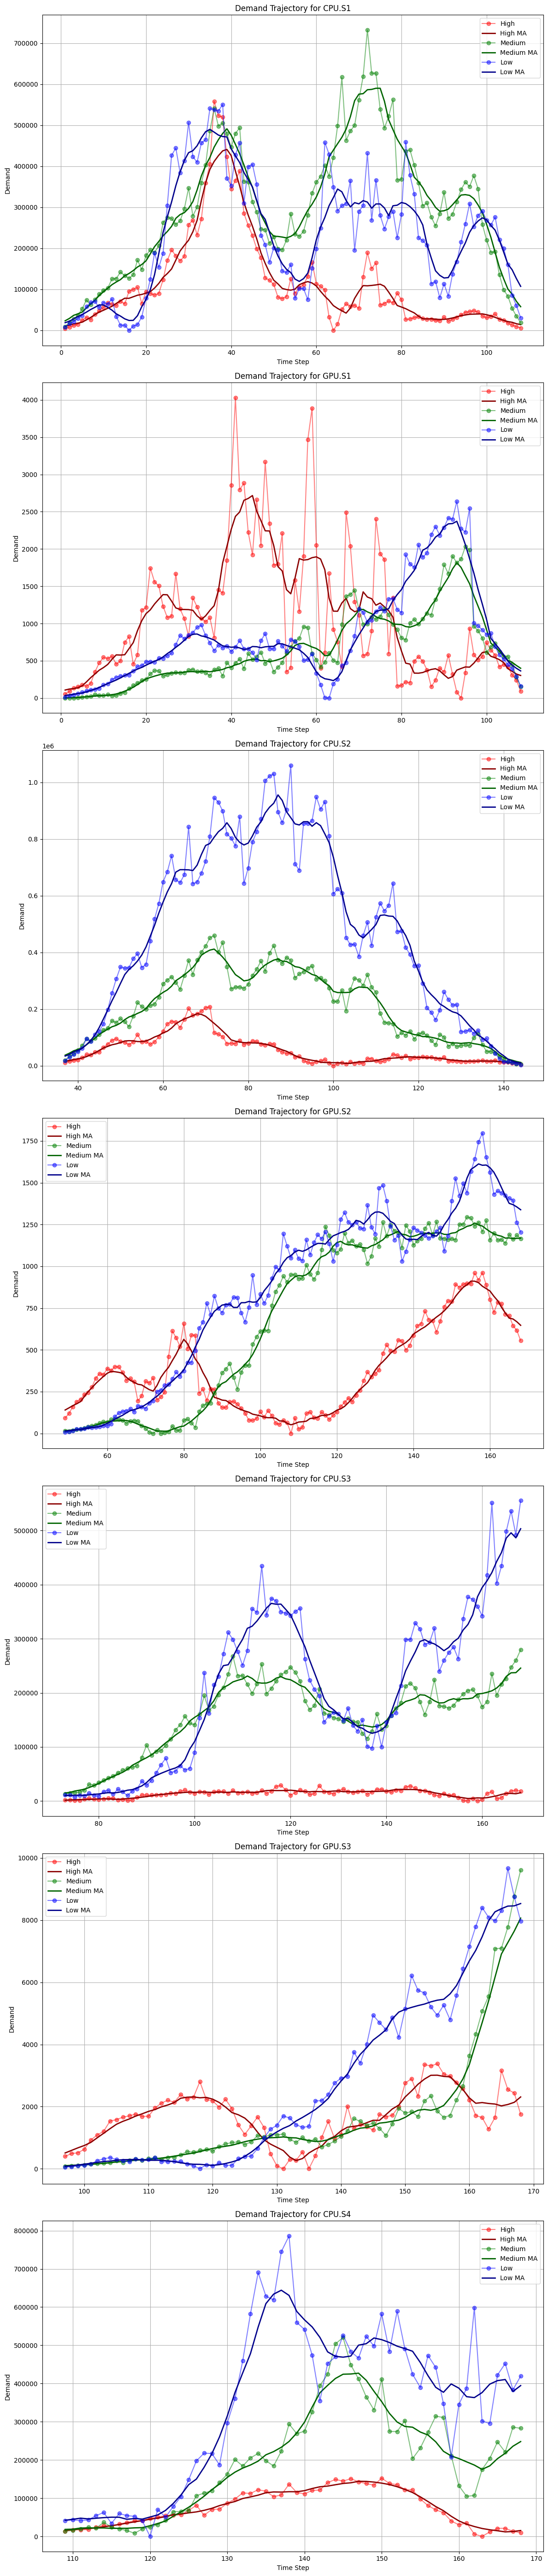

In [75]:
actual_demand = pd.read_csv('../data/test_data/actual_demand_1741.csv')
ma_demand_plot(actual_demand, window_size=8)

In [66]:
def gap_demand_plot(actual_demand: pd.DataFrame, gap_size: int = 7):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        # Calculate gap data
        gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
        gap_df.to_csv('gap_df.csv')

        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # Plot gap data
            ax.plot(gap_df['time_step'], gap_df[column], label=f'{column.capitalize()} Gap {gap_size}',
                    color=f'dark{color}', linestyle='-', linewidth=2, marker='o')
            
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

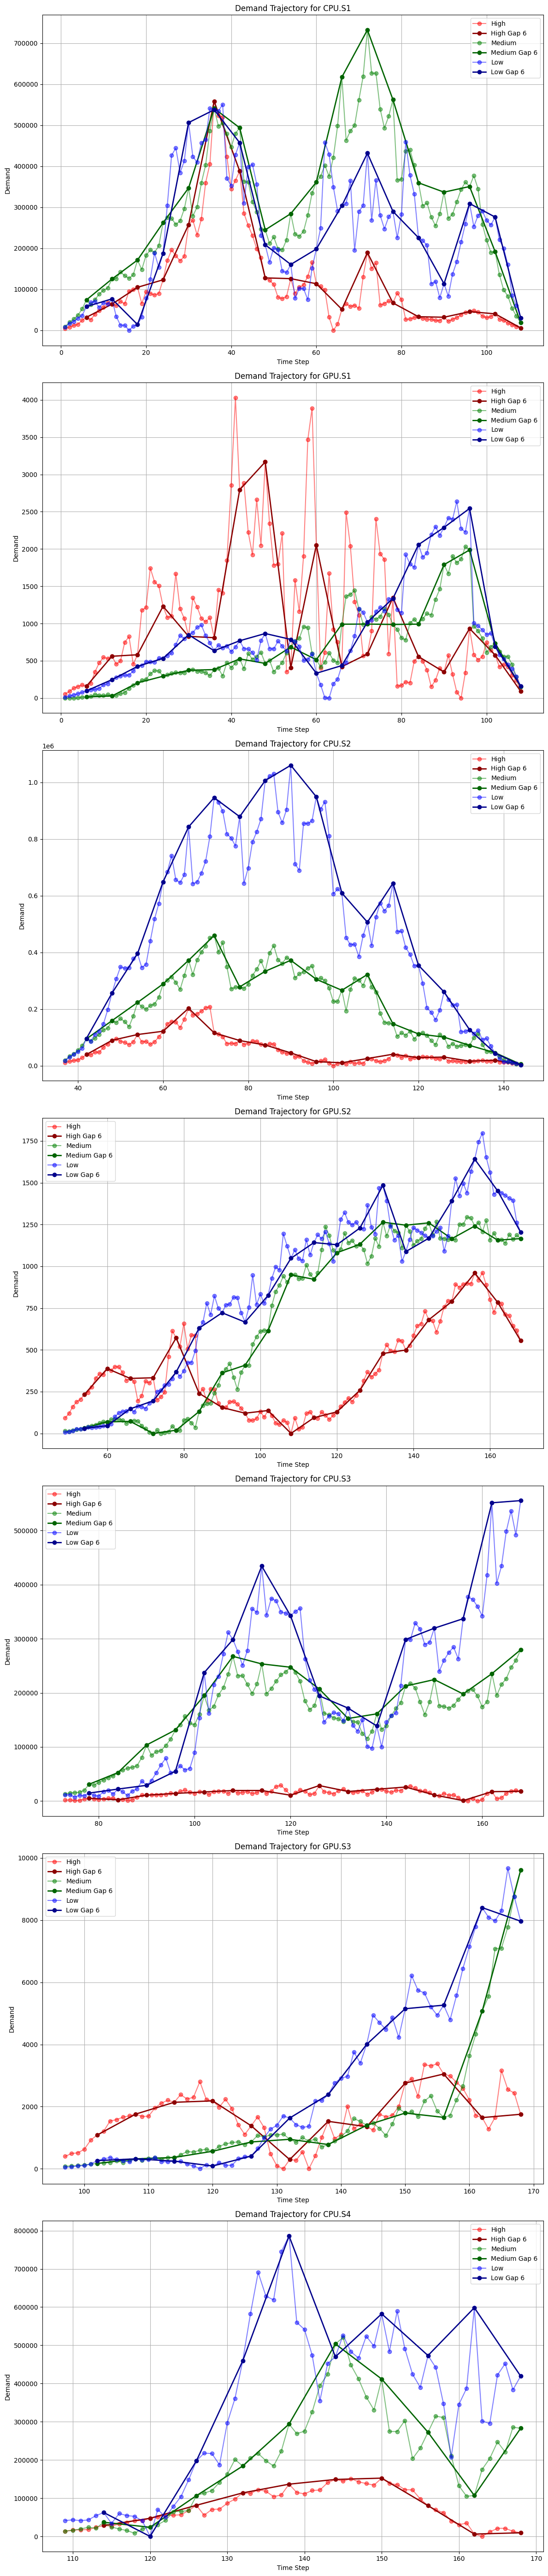

In [67]:
gap_demand_plot(actual_demand, gap_size=6)

In [17]:
gap_df = actual_demand[actual_demand['time_step'] % 6 == 0]
gap_df

In [72]:
def demand_plot(actual_demand: pd.DataFrame, window_size: int = 6, prominence: float = 0.1, width: int = 5):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]

            # Find peaks (points higher than the previous point)
            peaks = df_gen[df_gen[column] < df_gen[column].shift(3)]

            # Find peaks (points higher than the previous window_size points)
            # peaks = df_gen[df_gen[column] > df_gen[column].rolling(window=window_size, min_periods=1).max().shift(1)]
            # peaks, _ = find_peaks(df_gen[column], prominence=prominence, width=width)

            # Find pits (points lower than the previous window_size points)
            # pits = df_gen[df_gen[column] < df_gen[column].rolling(window=window_size, min_periods=1).min().shift(1)]\
            # valleys, _ = find_peaks(-df_gen[column], prominence=prominence, width=width)

            # Combine peaks and pits, sort by time_step, and drop duplicates
            # extrema = pd.concat([peaks, pits]).sort_values('time_step').drop_duplicates(subset=['time_step', column])
            # extrema = np.sort(np.concatenate([peaks, valleys]))
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # # Plot peaks with darker color
            ax.plot(peaks['time_step'], peaks[column], 
                    color=f'dark{color}', linestyle='-', linewidth=2)
            
            # Plot pits with darker color
            # ax.plot(pits['time_step'], pits[column], 
            #         color=f'dark{color}', linestyle='-', linewidth=2)

            # Plot extrema (peaks and pits) with darker color
            # ax.plot(extrema['time_step'], extrema[column],
            #         color=f'dark{color}', linestyle='-', linewidth=2)
            # ax.plot(df_gen['time_step'].iloc[extrema], df_gen[column].iloc[extrema],
            #         color=f'dark{color}', linestyle='-', linewidth=2, marker='o')
            
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

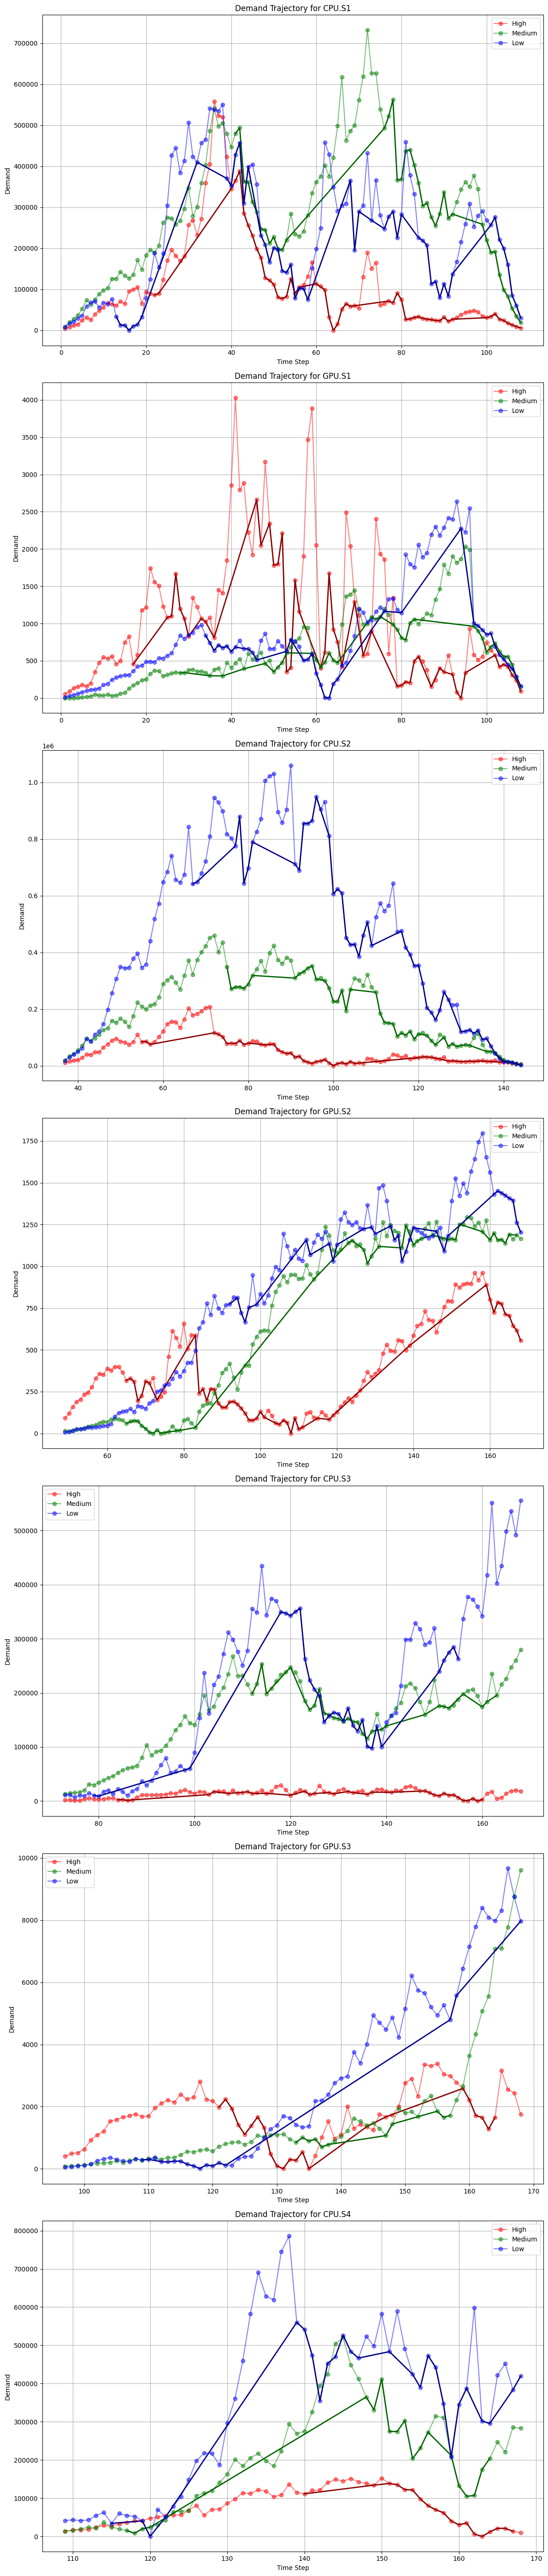

In [73]:
demand_plot(actual_demand, window_size=12)

In [71]:
server_generations = actual_demand['server_generation'].unique()
print(server_generations)

gap_size = 6
gap_dfs = []

for i, generation in enumerate(server_generations):
    df_gen = actual_demand[actual_demand['server_generation'] == generation]
    gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
    gap_dfs.append(gap_df)

combined_gap_df = pd.concat(gap_dfs, ignore_index=True).sort_values('time_step')
combined_gap_df.to_csv('combined_gap_df.csv', index=False)

['CPU.S1' 'GPU.S1' 'CPU.S2' 'GPU.S2' 'CPU.S3' 'GPU.S3' 'CPU.S4']


In [ ]:
server_generations = actual_demand['server_generation'].unique()
print(server_generations)

gap_size = 6
gap_dfs = []

for i, generation in enumerate(server_generations):
    df_gen = actual_demand[actual_demand['server_generation'] == generation]
    gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
    gap_dfs.append(gap_df)

combined_gap_df = pd.concat(gap_dfs, ignore_index=True).sort_values('time_step')
combined_gap_df.to_csv('combined_gap_df.csv', index=False)